In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import threading

# Intro

This notebook is intended to **infer economical fenomena in Chile by the visualization of different economic indicators**. The indicators being used are: 
1. The Monthly Economic Activity Index (Imacec).
2. Rate of unoccupancy nationally and in two distant regions of the country (*Antofagasta and Ñuble*).
3. The USD to CLP exchange rate.
4. Copper price (*USD/pound*).
5. Consumer price index (*CPI or IPC*).

*We are going to use the data from the 2014 to date.* 

To acquire the data, we will use web scraping.

## Acquiring Data with WebScraper

All the data being used in this notebook comes from the database of the *Banco Central de Chile* (**BCCh**) which is completely accesible and moreover, it allows you to use their **API** and extract the data directly by web scraping. **Nonetheless, before the automation of the extraction it is necesary to raise a request which would contain the data that it is supposed to be extracted by the user**.

The available series of data and the form to fill out by the user can be seen at:
https://si3.bcentral.cl/estadisticas/Principal1/Web_Services/index.htm

### Initially, we will state de codes of the series for every value we want to extract from the available data provided by the BCCh, which is presented in 'series.xlsx'.

In [2]:
series_codes = [
    'F032.IMC.IND.Z.Z.EP13.Z.Z.0.M',
    'F074.IPC.VAR.Z.Z.C.M',
    'F019.IPC.V12.10.M',
    'F019.PPB.PRE.100.D',
    'F073.TCO.PRE.Z.D',
    'F049.DES.TAS.INE9.10.M',
    'F049.DES.TAS.INE9.26.M',
    'F049.DES.TAS.INE9.12.M',
]

Then we read 'series.xlsx' and mask with ones whenever the series code denifed above matches the data so we can extract it. As the data provided by the BCCh is abundant and with every series code it might be several variations of the orininal data we will hold with the original ones and drop their variations. 

In [3]:
series_catalog = pd.read_excel("series.xlsx")
series_catalog['mask'] = np.where(series_catalog.loc[:,'Código'].isin(series_codes), 1, 0)
series_catalog = series_catalog[series_catalog['mask']==1]
series_catalog.sort_values(by='Código', inplace=True)

series_catalog = series_catalog.copy()
series_catalog.drop_duplicates(subset = 'Código', inplace=True)

series_catalog.columns.str.strip()
series_catalog['Serie'] = series_catalog.loc[:,'Nombre cuadro'].str.strip() + ' - ' +series_catalog.loc[:,'Nombre de la serie'].str.strip()

series_catalog

,Capítulo,Nombre cuadro,Código,Nombre de la serie,mask,Serie
14331,Economía Internacional,"Índice de precios al consumidor, variación en...",F019.IPC.V12.10.M,Estados Unidos,1,"Índice de precios al consumidor, variación en ..."
15294,Capitulo BDE Movil,"Precio del cobre (US$/libra), mensual",F019.PPB.PRE.100.D,Precios de productos básicos / Onza troy de Co...,1,"Precio del cobre (US$/libra), mensual - Precio..."
72,Principales Estadísticas Macro,Indicador mensual de actividad económica (IMACEC),F032.IMC.IND.Z.Z.EP13.Z.Z.0.M,Serie original (índice 2013=100),1,Indicador mensual de actividad económica (IMAC...
13448,Mercado Laboral y Demografía,"Tasas de desocupación, nacional y por región, ...",F049.DES.TAS.INE9.10.M,Nacional,1,"Tasas de desocupación, nacional y por región, ..."
13360,Mercado Laboral y Demografía,"Tasas de desocupación, nacional y por región, ...",F049.DES.TAS.INE9.12.M,Región de Antofagasta,1,"Tasas de desocupación, nacional y por región, ..."
13367,Mercado Laboral y Demografía,"Tasas de desocupación, nacional y por región, ...",F049.DES.TAS.INE9.26.M,Región del Ñuble,1,"Tasas de desocupación, nacional y por región, ..."
69,Principales Estadísticas Macro,Tipo de cambio,F073.TCO.PRE.Z.D,Tipo de cambio nominal (dólar observado $/U...,1,Tipo de cambio - Tipo de cambio nominal (dó...
15151,Capitulo BDE Movil,"IPC General, variación mensual",F074.IPC.VAR.Z.Z.C.M,"IPC General histórico, variación mensual",1,"IPC General, variación mensual - IPC General h..."


Let's create a dictionary to allow us to use it for the web scraper section.

In [4]:
seriesdict = dict(zip(series_catalog.loc[:,'Serie'], series_catalog.loc[:,'Código']))
seriesdict

{'Índice de precios al consumidor, variación en 12 meses, porcentaje - Estados Unidos': 'F019.IPC.V12.10.M',
 'Precio del cobre (US$/libra), mensual - Precios de productos básicos / Onza troy de Cobre. Dólares / oz': 'F019.PPB.PRE.100.D',
 'Indicador mensual de actividad económica (IMACEC) - Serie original (índice 2013=100)': 'F032.IMC.IND.Z.Z.EP13.Z.Z.0.M',
 'Tasas de desocupación, nacional y por región, INE (porcentaje) - Nacional': 'F049.DES.TAS.INE9.10.M',
 'Tasas de desocupación, nacional y por región, INE (porcentaje) - Región de Antofagasta': 'F049.DES.TAS.INE9.12.M',
 'Tasas de desocupación, nacional y por región, INE (porcentaje) - Región del Ñuble': 'F049.DES.TAS.INE9.26.M',
 'Tipo de cambio - Tipo  de  cambio  nominal (dólar observado $/USD)': 'F073.TCO.PRE.Z.D',
 'IPC General, variación mensual - IPC General histórico, variación mensual': 'F074.IPC.VAR.Z.Z.C.M'}

In [5]:
series = seriesdict.values()
series_name = seriesdict.keys()

## Web scraping
All data variables needed for the extraction are presented bellow (*Personal ID and pass not provided*).

We use the threading module in order optimize our time retrieving data by creating threads and then saving all the data into a dataframe and then merge it by the reduce functools.

In [6]:
dataframes = []

def get_data(item, user, password, firstdate, lastdate):

    url = 'https://si3.bcentral.cl/SieteRestWS/SieteRestWS.ashx?user={}&pass={}'\
          '&firstdate={}&lastdate={}&timeseries={}&function=GetSeries'.format(user, password, firstdate, lastdate, item)
    
    response = requests.get(url)
    response = response.json()
    series_name = list(seriesdict.keys())[list(seriesdict.values()).index(item)]
    response = response["Series"]["Obs"]
    
    df_scraped = pd.DataFrame(response)
    df_scraped.rename({'value': '{}'.format(series_name)}, axis='columns', inplace=True)
    dataframes.append(df_scraped)
    return dataframes 
    
threads = []

for i in series_codes:
    thread = threading.Thread(target=get_data, args=[i, 
                                                     'xxxxxxxxxxxx',
                                                     'xxxxxxxxxxxx',
                                                     '2014-01-31',
                                                     '2022-01-31',]
                             )
    thread.start()
    threads.append(thread) 

for thread in threads:
    thread.join()
    
# data cleaning
    
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

data_scraped = reduce(lambda  left,right: pd.merge(left,right,on=['indexDateString'], how='outer'), dataframes)
data_scraped = data_scraped[data_scraped.columns.drop(list(data_scraped.filter(regex='statusCode.*')))]

In order to avoid and recheck our raw_data we will create a copy of the dataframe created in the last cell.

In [7]:
data = data_scraped.copy(deep=True)
data.head()

,indexDateString,"Tasas de desocupación, nacional y por región, INE (porcentaje) - Nacional","Tasas de desocupación, nacional y por región, INE (porcentaje) - Región del Ñuble",Tipo de cambio - Tipo de cambio nominal (dólar observado $/USD),Indicador mensual de actividad económica (IMACEC) - Serie original (índice 2013=100),"Tasas de desocupación, nacional y por región, INE (porcentaje) - Región de Antofagasta","Precio del cobre (US$/libra), mensual - Precios de productos básicos / Onza troy de Cobre. Dólares / oz","Índice de precios al consumidor, variación en 12 meses, porcentaje - Estados Unidos","IPC General, variación mensual - IPC General histórico, variación mensual"
0,01-01-2014,6.2314665991056,7.8519894184926,NaN,97.698925440131,7.1280258758996,NaN,1.6,0.2
1,01-02-2014,6.1846947292971,7.708250390446,NaN,93.550666974764,7.7897842019301,NaN,1.1,0.5
2,01-03-2014,6.4964041476347,8.6074110800724,NaN,105.79817460075,7.3229648290014,NaN,1.5,0.8
3,01-04-2014,6.1441471565352,8.6300003474847,551.18,103.05050205472,8.1142042510018,3.0325,2,0.6
4,01-05-2014,6.324242958052,7.4921605618196,NaN,103.72294789161,7.6745050302736,NaN,2.1,0.3


We want to change the labels for every column in order to make them more ergonomic.

In [8]:
data.columns

Index(['indexDateString',
       'Tasas de desocupación, nacional y por región, INE (porcentaje) - Nacional',
       'Tasas de desocupación, nacional y por región, INE (porcentaje) - Región del Ñuble',
       'Tipo de cambio - Tipo  de  cambio  nominal (dólar observado $/USD)',
       'Indicador mensual de actividad económica (IMACEC) - Serie original (índice 2013=100)',
       'Tasas de desocupación, nacional y por región, INE (porcentaje) - Región de Antofagasta',
       'Precio del cobre (US$/libra), mensual - Precios de productos básicos / Onza troy de Cobre. Dólares / oz',
       'Índice de precios al consumidor, variación en 12 meses, porcentaje - Estados Unidos',
       'IPC General, variación mensual - IPC General histórico, variación mensual'],
      dtype='object')

#### As we might expect:

By threading, our columns will be in different order every time the process finishes. So we need a way to assign our rename for columns (we want to rename every column for readablility) by obtaining the order of the columns that our dataframe has.

In [9]:
d = list(
    (
        (enumerate(np.where(data.columns.str.contains('Estados Unidos'), 'IPC - EEUU', False))),
        (enumerate(np.where(data.columns.str.contains('Date'), 'Date', False))),
        (enumerate(np.where(data.columns.str.contains('Ñuble'), 'Unoccupied (%) - Ñuble region', False))),
        (enumerate(np.where(data.columns.str.contains('Antofagasta'), 'Unoccupied (%) - Antofagasta region', False))),
        (enumerate(np.where(data.columns.str.contains('dólar'), 'Exchange rate', False))),
        (enumerate(np.where(data.columns.str.contains('Nacional'), 'Unoccupied (%) - Nationally', False))),
        (enumerate(np.where(data.columns.str.contains('IPC'), 'IPC', False))),
        (enumerate(np.where(data.columns.str.contains('IMACEC'), 'Imacec rate', False))),
        (enumerate(np.where(data.columns.str.contains('cobre'), 'Copper (USD/Lbs)', False))),
    )
)

lst=[]
for item in d:
    for key, value in item:
        if value!='False':
            lst.append((key, value))

lst.sort(key=lambda tup: tup[0])
lst

[(0, 'Date'),
 (1, 'Unoccupied (%) - Nationally'),
 (2, 'Unoccupied (%) - Ñuble region'),
 (3, 'Exchange rate'),
 (4, 'Imacec rate'),
 (5, 'Unoccupied (%) - Antofagasta region'),
 (6, 'Copper (USD/Lbs)'),
 (7, 'IPC - EEUU'),
 (8, 'IPC')]

Change column labels and adaptation of Imacec as it **summarizes the activity of the different branches of the economy in a given month, at prices from the previous year**.

In [10]:
data.dropna(inplace=True)
data.columns = [x[1] for x in lst]
columnstofloat = data.columns[1:]
data[columnstofloat] = data.loc[:,columnstofloat].astype('float64').apply(lambda x: round(x,1))
data['Imacec rate'] = data.loc[:, 'Imacec rate'] - data.loc[:, 'Imacec rate'].shift(12)
data = data.iloc[12:] #remove first year

#### Let's have a general look to our data.

In [11]:
data.head()

,Date,Unoccupied (%) - Nationally,Unoccupied (%) - Ñuble region,Exchange rate,Imacec rate,Unoccupied (%) - Antofagasta region,Copper (USD/Lbs),IPC - EEUU,IPC
13,01-02-2015,6.2,7.9,NaN,1.9,6.0,NaN,0.0,0.4
14,01-03-2015,6.2,7.7,NaN,2.3,7.7,NaN,-0.1,0.6
15,01-04-2015,6.4,7.4,626.6,2.9,7.1,2.8,-0.2,0.6
16,01-05-2015,6.8,7.6,NaN,1.6,7.4,NaN,0.0,0.2
17,01-06-2015,6.7,7.4,616.7,2.8,6.5,2.8,0.1,0.5


In [12]:
data.describe()

,Unoccupied (%) - Nationally,Unoccupied (%) - Ñuble region,Exchange rate,Imacec rate,Unoccupied (%) - Antofagasta region,Copper (USD/Lbs),IPC - EEUU,IPC
count,84.000000,84.000000,45.000000,84.000000,84.000000,45.000000,84.000000,84.000000
mean,7.753571,7.992857,697.828889,2.450000,8.758333,2.924444,2.048810,0.303571
std,1.664690,1.497290,64.383720,6.765495,1.682311,0.698751,1.631873,0.306730
min,5.900000,4.800000,593.600000,-17.700000,5.600000,2.100000,-0.200000,-0.400000
25%,6.800000,7.175000,651.800000,0.875000,7.500000,2.400000,1.100000,0.100000
50%,7.200000,7.800000,679.200000,2.100000,8.500000,2.800000,1.800000,0.300000
75%,7.825000,8.825000,727.800000,3.425000,9.525000,3.100000,2.400000,0.500000
max,13.100000,12.100000,852.000000,19.800000,13.200000,4.600000,7.500000,1.300000


#### Data visualization.

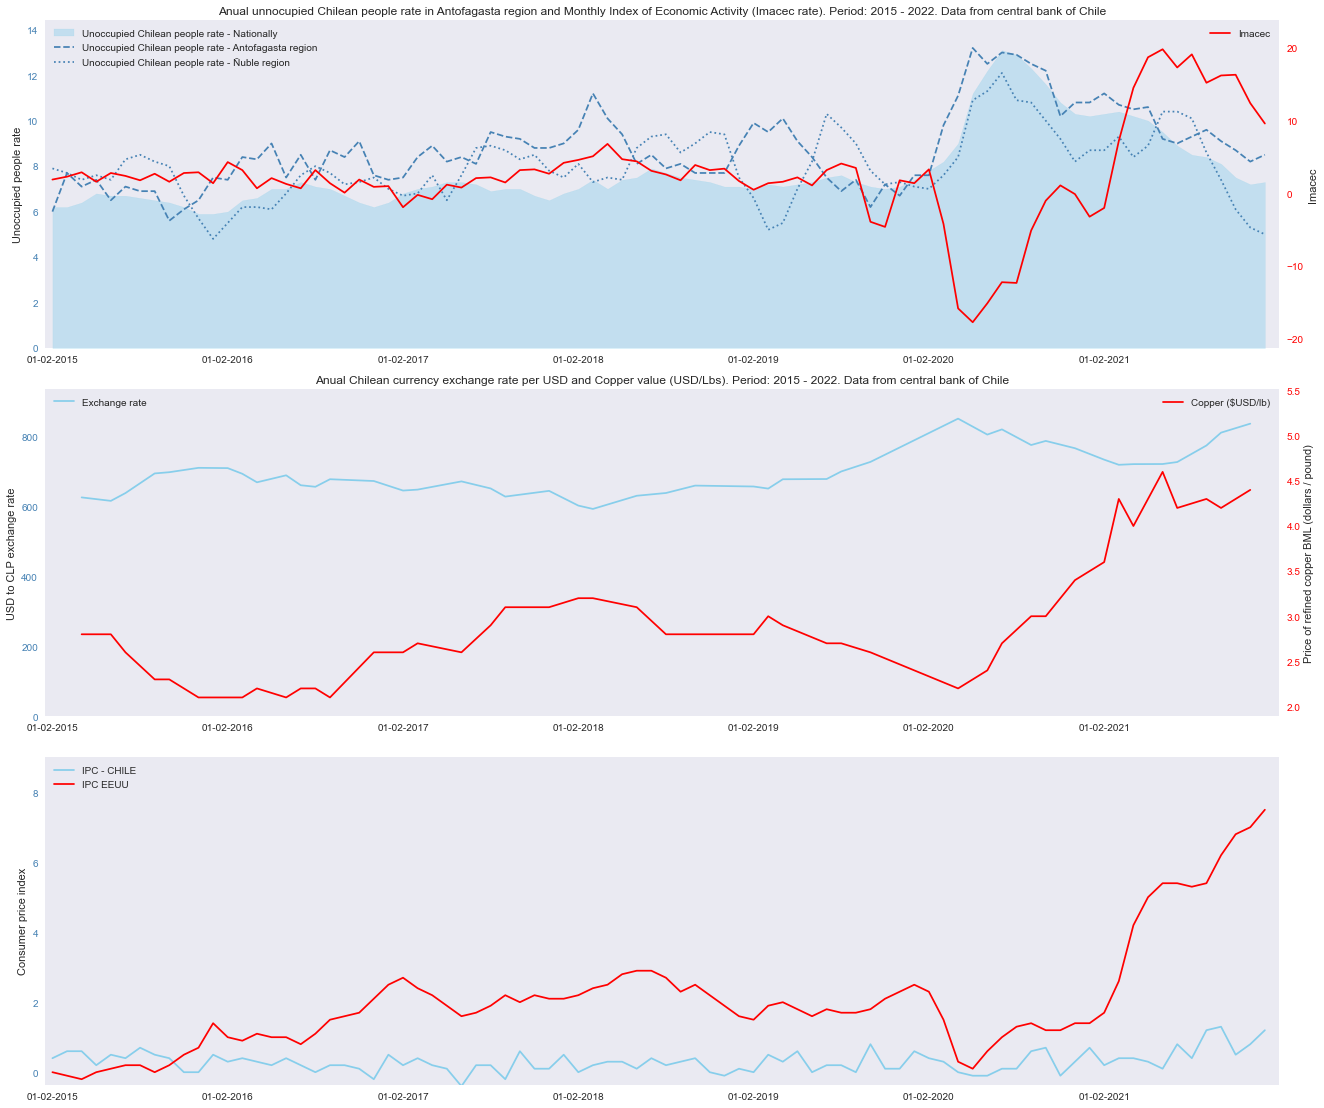

In [14]:
x = np.arange(0,len(data),1)
fig, (ax1,ax2,ax3) = plt.subplots(3)
fig.set_size_inches(18.5, 15.5)

plt.style.use('seaborn')

plt.setp([ax1,ax2,ax3], xticks=range(0,len(data),12), xticklabels=data.loc[:,'Date'][0:-1:12])

###########################################################################################################################
#Unoccupied - Imacec
ax1.fill_between(x,data.loc[:,'Unoccupied (%) - Nationally'], color="skyblue", alpha=0.4,label='Unoccupied Chilean people rate - Nationally')
ax1.plot(x,data.loc[:,'Unoccupied (%) - Antofagasta region'],\
        color='steelblue', linestyle='dashed',label='Unoccupied Chilean people rate - Antofagasta region')
ax1.plot(x,data.loc[:,'Unoccupied (%) - Ñuble region'],\
        color='steelblue', linestyle='dotted',label='Unoccupied Chilean people rate - Ñuble region')
ax1.set_ylabel('Unoccupied people rate')
ax1.grid(False)
ax1.legend(loc='upper left')

ax11 = ax1.twinx()
ax11.plot(x,data.loc[:,'Imacec rate'],color='red', label = 'Imacec')
ax11.set_ylabel('Imacec')
ax11.grid(False)
ax11.legend(loc='upper right')

ax1.set_title('Anual unnocupied Chilean people rate in Antofagasta region and Monthly Index of Economic Activity (Imacec rate). Period: 2015 - 2022. Data from central bank of Chile')
plt.tight_layout()

ax1.axis([-0.5,len(data),0, data.loc[:,'Unoccupied (%) - Nationally'].max()*1.1])
ax1.tick_params(axis='y', colors='steelblue')
ax11.axis([-0.5,len(data), data.loc[:,'Imacec rate'].min()*1.2, data.loc[:,'Imacec rate'].max()*1.2])
ax11.tick_params(axis='y', colors='red')

###########################################################################################################################
#Exchange rate USD - Copper price

# mask for line drawing between points ignoring missing data
s1mask = np.isfinite(data.loc[:,'Exchange rate'])
s2mask = np.isfinite(data.loc[:,'Copper (USD/Lbs)'])

ax2.plot(x[s1mask],data.loc[:,'Exchange rate'][s1mask],color='skyblue', label='Exchange rate')
ax2.grid(False)
ax2.set_title('Anual Chilean currency exchange rate per USD and Copper value (USD/Lbs). Period: 2015 - 2022. Data from central bank of Chile')
ax2.legend(loc='upper left')

ax22 = ax2.twinx()
ax22.plot(x[s2mask],data.loc[:,'Copper (USD/Lbs)'][s2mask],color='red', label= 'Copper ($USD/lb)')
ax22.grid(False)


plt.tight_layout()
ax2.axis([-0.5,len(data),0, data.loc[:,'Exchange rate'].max()*1.1])
ax22.axis([-0.5,len(data), data.loc[:,'Copper (USD/Lbs)'].min()*0.9, data.loc[:,'Copper (USD/Lbs)'].max()*1.2])


ax2.tick_params(axis='y', colors='steelblue')
ax22.tick_params(axis='y', colors='red')

ax2.set_ylabel('USD to CLP exchange rate')
ax22.set_ylabel('Price of refined copper BML (dollars / pound)')
ax22.legend(loc='upper right')


###########################################################################################################################
#IPC
s3mask = np.isfinite(data.loc[:,'IPC'])
s4mask = np.isfinite(data.loc[:,'IPC - EEUU'])

ax3.plot(x[s3mask],data.loc[:,'IPC'][s3mask],color='skyblue', label= 'IPC - CHILE')
ax3.plot(x[s4mask],data.loc[:,'IPC - EEUU'][s4mask],color='red', label= 'IPC EEUU')
ax3.grid(False)

plt.tight_layout()

ax3.axis([-0.5,len(data), data.loc[:,['IPC', 'IPC - EEUU']].min(axis=1).min()*0.9, 
          data.loc[:,['IPC', 'IPC - EEUU']].max(axis=1).max()*1.2])

ax3.tick_params(axis='y', colors='steelblue')
ax3.set_ylabel('Consumer price index')
ax3.legend(loc='upper left')

plt.savefig('Imacec-unnocupied_exchangerate-Coppervalue.png')